<h1 style="font-family:verdana;"> <center>📚 Introduction 📚</center> </h1>

***

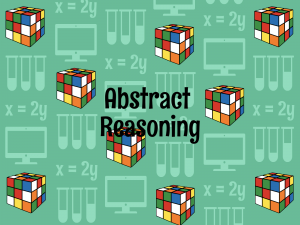


<div class="alert alert-block alert-info" style="font-size:15px; font-family:verdana; line-height: 1.4em;">
    <center>
        📌 <span style="color:crimson;">Abstraction and Reasoning Challenge (ARC).</span> 
</center> 
    <center>
    In this kernel we will build an algorithm that solve abstract reasoning tasks. <br>
<br>
        Classic machine learning problems generally involve one specific task which can be solved by training on millions of data samples. But in this challenge, we need to build an algorithm that can learn patterns from a minimal number of examples.
    </center>
    
    
</div>

<center><h2>Importing Libraries</h2></center>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
from pandas.io.json import json_normalize
import json
import time

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
%matplotlib inline

import plotly.express as px
import plotly.figure_factory as ff

import torch
import torch.nn as nn
T = torch.Tensor
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


from keras.utils import to_categorical

<h2><center>Loading Data</center>

In [ ]:
# PATHS

PATH = '../input/abstraction-and-reasoning-challenge/'
TRAIN_PATH = PATH + 'training/'
TEST_PATH = PATH + 'test/'

train_input, train_output, train_ids = [], [], []
test_input,  test_output, test_ids = [], [], []
file_names = []

In [ ]:
# Function to Read file data

def read_json():
    
    idx = 0
    
    for file_name in os.listdir(TRAIN_PATH):
        full_file_path = TRAIN_PATH + file_name
        with open (TRAIN_PATH+file_name) as f:
            file = json.load(f)
            #Each train data has more than one ip/op pairs, so looping over each pair 
            for i in range(len(file['train'])):
                in_data, out_data = file['train'][i]['input'],file['train'][i]['output']
                # Tagging all the train data under one comming id for segregation of different sets
                train_ids.append(idx)
                train_input.append(in_data)
                train_output.append(out_data)
                file_names.append(file_name)

            # There is one set of test data in each file sample, hence no need to loop     
            in_data, out_data = file['test'][0]['input'],file['test'][0]['output']
            test_ids.append(idx)
            test_input.append(in_data)
            test_output.append(out_data)

        idx +=1
    
read_json()                          
train_df = pd.DataFrame(zip(train_ids, train_input, train_output, file_names), columns = ['id','input','output','filename'])
test_df = pd.DataFrame(zip(test_ids, test_input, test_output), columns = ['id','input','output'])          

In [ ]:
display(train_df.head(10))
display(test_df.head(4))

<center><h2>Plot Train/Test Input/Output</h2></center>

In [ ]:
cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
fig, ax = plt.subplots(1,4, figsize=(15,5))
norm = colors.Normalize(vmin=0, vmax=9)

ax[0].imshow(train_df[train_df['id'] == 85]['input'].iloc[0], cmap=cmap, norm=norm)
ax[1].imshow(train_df[train_df['id'] == 85]['output'].iloc[0], cmap=cmap, norm=norm)
ax[2].imshow(test_df[test_df['id'] == 85]['input'].iloc[0], cmap=cmap, norm=norm)
ax[3].imshow(test_df[test_df['id'] == 85]['output'].iloc[0], cmap=cmap, norm=norm)

ax[0].set_xticklabels([])
ax[1].set_xticklabels([])
ax[2].set_xticklabels([])
ax[3].set_xticklabels([])

ax[0].set_yticklabels([])
ax[1].set_yticklabels([])
ax[2].set_yticklabels([])
ax[3].set_yticklabels([])


ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
ax[3].grid(True)

_ = ax[0].set_title('Train Input')
_ = ax[1].set_title('Train Output')
_ = ax[2].set_title('Test Input')
_ = ax[3].set_title('Test Input')

<center><h2>Plotting 3 Train samples and corresponding Test Input & Output</h2></center>

<center>Plot function</center>

In [ ]:
'''
Pass the id of a particular train/test sample, the function will 
plot 3 train inputs and thier corresponding outputs.
The 4th pair ip/op plot would be of Test sample belonging to the respective train samples
'''
def plot_abstracts(idx):
    cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    fig, ax = plt.subplots(2,4, figsize=(15,10))
    norm = colors.Normalize(vmin=0, vmax=9)
    ax[0][0].imshow(train_df[train_df['id'] == idx]['input'].iloc[0], cmap=cmap, norm=norm)
    ax[0][1].imshow(train_df[train_df['id'] == idx]['output'].iloc[0], cmap=cmap, norm=norm)
    ax[0][2].imshow(train_df[train_df['id'] == idx]['input'].iloc[1], cmap=cmap, norm=norm)
    ax[0][3].imshow(train_df[train_df['id'] == idx]['output'].iloc[1], cmap=cmap, norm=norm)

    ax[1][0].imshow(train_df[train_df['id'] == idx]['input'].iloc[2], cmap=cmap, norm=norm)
    ax[1][1].imshow(train_df[train_df['id'] == idx]['output'].iloc[2], cmap=cmap, norm=norm)
    ax[1][2].imshow(test_df[test_df['id'] == idx]['input'].iloc[0], cmap=cmap, norm=norm)
    ax[1][3].imshow(test_df[test_df['id'] == idx]['output'].iloc[0], cmap=cmap, norm=norm)

    ax[0][0].set_xticklabels([])
    ax[0][1].set_xticklabels([])
    ax[0][2].set_xticklabels([])
    ax[0][3].set_xticklabels([])

    ax[1][0].set_xticklabels([])
    ax[1][1].set_xticklabels([])
    ax[1][2].set_xticklabels([])
    ax[1][3].set_xticklabels([])

    ax[0][0].set_yticklabels([])
    ax[0][1].set_yticklabels([])
    ax[0][2].set_yticklabels([])
    ax[0][3].set_yticklabels([])

    ax[1][0].set_yticklabels([])
    ax[1][1].set_yticklabels([])
    ax[1][2].set_yticklabels([])
    ax[1][3].set_yticklabels([])

    ax[0][0].grid(True)
    ax[0][1].grid(True)
    ax[0][2].grid(True)
    ax[0][3].grid(True)

    ax[1][0].grid(True)
    ax[1][1].grid(True)
    ax[1][2].grid(True)
    ax[1][3].grid(True)

    _ = ax[0][0].set_title('Train Input')
    _ = ax[0][1].set_title('Train Output')
    _ = ax[0][2].set_title('Train Input')
    _ = ax[0][3].set_title('Train Input')

    _ = ax[1][0].set_title('Train Input')
    _ = ax[1][1].set_title('Train Output')
    _ = ax[1][2].set_title('Test Input')
    _ = ax[1][3].set_title('Test Input')
    
    plt.show()

plot_abstracts(110)

In [ ]:
plot_abstracts(180)

In [ ]:
plot_abstracts(150)

<center><h2>Creating Dataset for PyTorch</h2></center>

In [ ]:
# Creating 1000 samples from a set of training sample for Training
def repeat_matrix(a):
    return np.concatenate([a]*((1000 // len(a)) + 1))[:1000]


def get_outp(outp):
    outp_matrix_dims = np.shape(outp)
    outp_probs_len = np.shape(outp)[0]*np.shape(outp)[1]*10
    outp = to_categorical(np.array(outp).flatten(),
                          num_classes=10).flatten()

    return outp, outp_probs_len, outp_matrix_dims

In [ ]:
class CreateDataset(Dataset):
    def __init__(self, X, y):
        self.X = repeat_matrix(X)
        self.y = repeat_matrix(y)
        
    def __len__(self):
        return SIZE
    
    def __getitem__(self, idx):
        inp = self.X[idx]
        outp = self.y[idx]
        outp, outp_probs_len, outp_matrix_dims = get_outp(outp)
        
        return inp, outp, outp_probs_len, outp_matrix_dims, self.y

<center><h3>Creating Network of Conv & Dense Layers</center>

In [ ]:
class Net(nn.Module):
    def __init__(self, inp_dim=(10, 10), outp_dim=(10, 10)):
        super(Net, self).__init__()
        
        KERNEL_SIZE = 3
        if inp_dim[0] < 5 or inp_dim[1] < 5:
            KERNEL_SIZE = 1

        self.conv2d_1 = nn.Conv2d(3, 50, kernel_size=KERNEL_SIZE)
        self.conv2d_2 = nn.Conv2d(50, 100, kernel_size=KERNEL_SIZE)
        self.dense_1 = nn.Linear(100, outp_dim[0]*outp_dim[1]*10)
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        

    def forward(self, x, outp_dim):
        """
        1.  x.shape = (128,width,height)  - 128 is the batch size set by DataLoader
            unsqueeze will add a new dimension (1) to the dataset
            x.shape = (1, 128, height, width)
        2.  [x.unsqueeze(0)*3] will create three tensors having new dimension (3 channels for RGB )
            we now concatenate the three tensors creating a new tensor
            x.shape = (3, 128, width, height)
        3.  Format of Tensor for Training-
            # 4d: [batch_size, channels, height, width]
            # used for nn.Conv2d() input.
            
            for this we just have to change the places of batch_size(128) and channels(3) in x
            hence we use permute to reshape x
            
        """
        x = torch.cat([x.unsqueeze(0)]*3)
        x = x.permute((1, 0, 2, 3)).float()
        self.conv2d_1.in_features = x.shape[1]
        conv_1_out = self.relu(self.conv2d_1(x))
        self.conv2d_2.in_features = conv_1_out.shape[1]
        conv_2_out = self.relu(self.conv2d_2(conv_1_out))
        
        self.dense_1.out_features = outp_dim
        feature_vector, _ = torch.max(conv_2_out, 2)
        feature_vector, _ = torch.max(feature_vector, 2)
        logit_outputs = self.dense_1(feature_vector)
        
        out = []
        for idx in range(logit_outputs.shape[1]//10):
            out.append(self.softmax(logit_outputs[:, idx*10: (idx+1)*10]))
        return torch.cat(out, axis=1)

In [ ]:
def transform_dim(inp_dim, outp_dim, test_dim):
    return (test_dim[0]*outp_dim[0]/inp_dim[0],
            test_dim[1]*outp_dim[1]/inp_dim[1])

def resize(x, test_dim, inp_dim):
    if inp_dim == test_dim:
        return x
    else:
        return cv2.resize(flt(x), inp_dim,
                          interpolation=cv2.INTER_AREA)

def flt(x): return np.float32(x)
def npy(x): return x.cpu().detach().numpy()
def itg(x): return np.int32(np.round(x))

<center><h3>Training Model</center>

In [ ]:
EPOCHS = 50
BATCH_SIZE = 128
SIZE=1000

idx = 0
start = time.time()
pred_y = []
test_y = []

for id_val in list(set(train_df['id'])):
    X_train = train_df[train_df['id'] == id_val]['input'].values
    X_train = [cv2.resize(np.float32(x), np.shape(X_train[0])) for x in X_train]
    
    y_train = train_df[train_df['id'] == id_val]['output'].values
    y_train = [cv2.resize(np.float32(y), np.shape(y_train[0])) for y in y_train]
    
    y_test = test_df[test_df['id'] == id_val]['output'].values
    y_test = [cv2.resize(np.float32(y), np.shape(y_train[0])) for y in y_test]
    
    X_test = test_df[test_df['id'] == id_val]['input'].values
    X_test = np.array([cv2.resize(np.float32(x), np.shape(X_train[0])) for x in X_test])
    X_test = X_test.reshape(np.shape(X_train[0]))
    
    
    train_set = CreateDataset(X_train, y_train)
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

    inp_dim = np.array(X_train[0]).shape
    outp_dim = np.array(y_train[0]).shape
    network = Net(inp_dim, outp_dim).cuda()
    optimizer = Adam(network.parameters(), lr=0.01)
    
    for epoch in range(EPOCHS):
        for train_batch in train_loader:
            train_X, train_y, out_d, d, out = train_batch
            train_preds = network.forward(train_X.cuda(), out_d.cuda())
            train_loss = nn.MSELoss()(train_preds, train_y.cuda())
            
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

    end = time.time() 
    print(f"Train sample id {idx}")
    print("Train loss: " + str(np.round(train_loss.item(), 3)) + "   " +\
          "Total time: " + str(np.round(end - start, 1)) + " s" + "\n")
    
    
    test_dim = X_test.shape
    test_preds = npy(network.forward(T(X_test).unsqueeze(0).cuda(), out_d.cuda()))
    test_preds = np.argmax(test_preds.reshape((10, *outp_dim)), axis=0)
    pred_y.append(itg(resize(test_preds, np.shape(test_preds),
                                           tuple(itg(transform_dim(inp_dim,
                                                                   outp_dim,
                                                                   test_dim))))))
    test_y.append(y_test)
    
    # Limiting Training to 50 samples
    if (idx==50):
        break
   
    idx += 1
